# Задание 1

In [2]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 23.4 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824028 sha256=919770e028f3deff4bf2e86e4942c07fdfae91dd465739e244fe245546665b8a
  Stored in directory: /root/.cache/pip/wheels/6c/e3/9b/0525ce8a69478916513509d43693511463c6468db0de237c86
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


+--------------------+--------------------+-----------+-------+-----+----+-----------+
|                Name|              Author|User_Rating|Reviews|Price|Year|      Genre|
+--------------------+--------------------+-----------+-------+-----+----+-----------+
|10-Day Green Smoo...|            JJ Smith|        4.7|  17350|  8.0|2016|Non Fiction|
|   11/22/63: A Novel|        Stephen King|        4.6|   2052| 22.0|2011|    Fiction|
|12 Rules for Life...|  Jordan B. Peterson|        4.7|  18979| 15.0|2018|Non Fiction|
|1984 (Signet Clas...|       George Orwell|        4.7|  21424|  6.0|2017|    Fiction|
|5,000 Awesome Fac...|National Geograph...|        4.8|   7665| 12.0|2019|Non Fiction|
|A Dance with Drag...| George R. R. Martin|        4.4|  12643| 11.0|2011|    Fiction|
|A Game of Thrones...| George R. R. Martin|        4.7|  19735| 30.0|2014|    Fiction|
|A Gentleman in Mo...|         Amor Towles|        4.7|  19699| 15.0|2017|    Fiction|
|A Higher Loyalty:...|         James Comey|

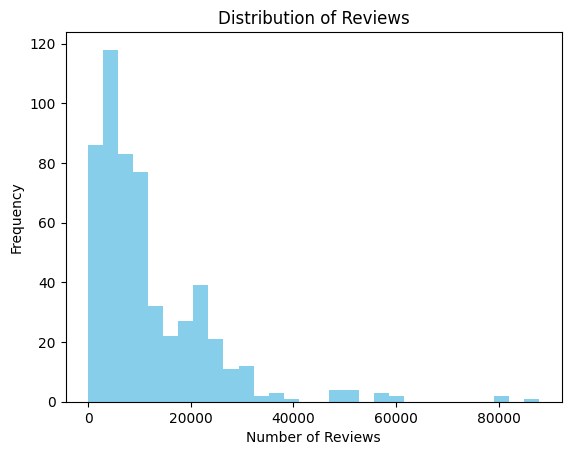

+--------------------------+------------------------+--------------------+
|corr(User_Rating, Reviews)|corr(User_Rating, Price)|corr(Reviews, Price)|
+--------------------------+------------------------+--------------------+
|      -0.00172900883196...|    -0.13308630757790718|-0.10918188342780513|
+--------------------------+------------------------+--------------------+



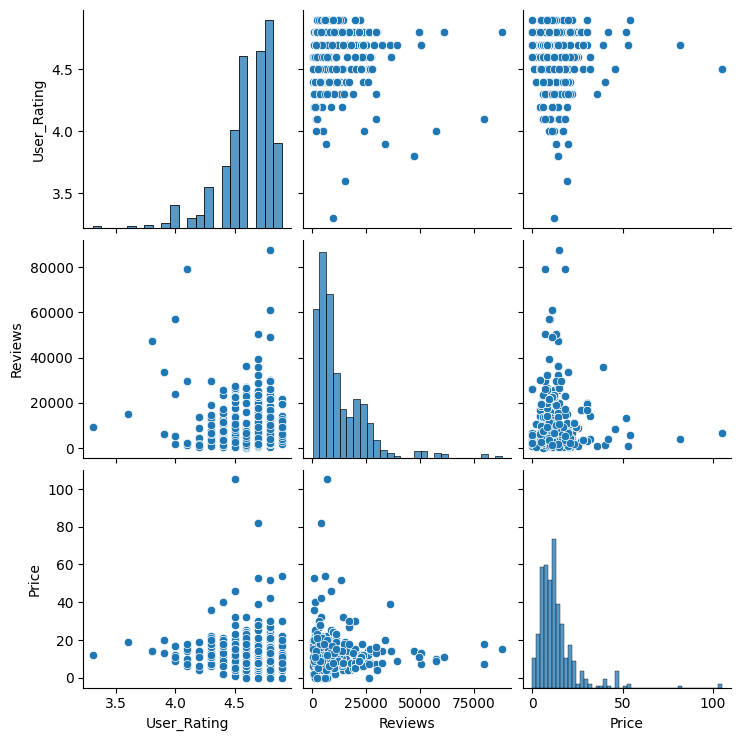

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, FloatType, IntegerType, StringType
from pyspark.sql.functions import corr


#Создать спарк сессию
spark_session = SparkSession.builder.getOrCreate()

#Прочитать датасет в датафрейм
csvSchema = StructType([StructField("Name",StringType()),
                        StructField("Author",StringType()),
                        StructField("User_Rating",FloatType()),
                        StructField("Reviews",IntegerType()),
                        StructField("Price",FloatType()),
                        StructField("Year",StringType()),
                        StructField("Genre",StringType())])
df = spark_session.read.csv("bestsellers with categories.csv",header=True, schema=csvSchema)
df.show()

#Используя только RDD вычислить среднюю цену всех книг, у которых рейтинг выше 4.7
df.filter(df.User_Rating > 4.7).groupBy().avg("Price").show()

#Построить гистограмму распределения рецензий (столбец Reviews)
reviews_rdd = df.select('Reviews').rdd.map(lambda row: row[0])
plt.hist(reviews_rdd.collect(), bins=30, color='skyblue')
plt.title('Distribution of Reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.show()

#Построить матрицу корреляции для столбцов "User Rating", "Reviews" и "Price".
correlations = df.select(corr('User_Rating', 'Reviews'),
                         corr('User_Rating', 'Price'),
                         corr('Reviews', 'Price'))
correlations.show()

#Используя библиотеку seaborn построить парные графики (pairplots) столбцов "User Rating", "Reviews" и "Price"
columns = ['User_Rating', 'Reviews', 'Price']
data = df.select(columns).toPandas()

# Строим парные графики
sns.pairplot(data)

# Задание 2

In [4]:
df.createOrReplaceTempView("Bestsellers")

#Найдите автора с самым высоким рейтингом
spark_session.sql("Select Author, User_Rating  From Bestsellers ORDER BY User_Rating DESC Limit 1").show()

+---------------+-----------+
|         Author|User_Rating|
+---------------+-----------+
|Bill Martin Jr.|        4.9|
+---------------+-----------+



In [5]:
#Найдите трех авторов с самым низким рейтингом
spark_session.sql("Select Author, User_Rating  From Bestsellers ORDER BY User_Rating Limit 3").show()

+------------+-----------+
|      Author|User_Rating|
+------------+-----------+
|J.K. Rowling|        3.3|
|  Harper Lee|        3.6|
|   E L James|        3.8|
+------------+-----------+



In [8]:
#Определите какой автор получил наибольшее количество рецензий
spark_session.sql("Select Author, Sum(Reviews)  From Bestsellers Group By Author ORDER BY Sum(Reviews) DESC Limit 1").show()

+---------------+------------+
|         Author|sum(Reviews)|
+---------------+------------+
|Suzanne Collins|      278329|
+---------------+------------+



In [14]:
#Определите какой автор написал наибольшее количество книг за весь доступный в данных период
spark_session.sql("Select Author, count(DISTINCT Name) From Bestsellers Group By Author ORDER BY count(DISTINCT  Name) DESC Limit 1").show()

+-----------+--------------------+
|     Author|count(DISTINCT Name)|
+-----------+--------------------+
|Jeff Kinney|                  12|
+-----------+--------------------+



In [ ]:
#Определите какая книга жанра "Fiction" имеет самый маленький рейтинг

In [17]:
spark_session.sql("Select Name, Genre, User_Rating From Bestsellers Where Genre = 'Fiction' ORDER BY User_Rating Limit 1").show()

+------------------+-------+-----------+
|              Name|  Genre|User_Rating|
+------------------+-------+-----------+
|The Casual Vacancy|Fiction|        3.3|
+------------------+-------+-----------+



In [19]:
#Определите какая книга жанра "Non Fiction" имеет самый высокий рейтинг
spark_session.sql("Select Name, Genre, User_Rating From Bestsellers Where Genre = 'Non Fiction' ORDER BY User_Rating DESC Limit 1").show()

+--------------------+-----------+-----------+
|                Name|      Genre|User_Rating|
+--------------------+-----------+-----------+
|Hamilton: The Rev...|Non Fiction|        4.9|
+--------------------+-----------+-----------+



# Задание 3

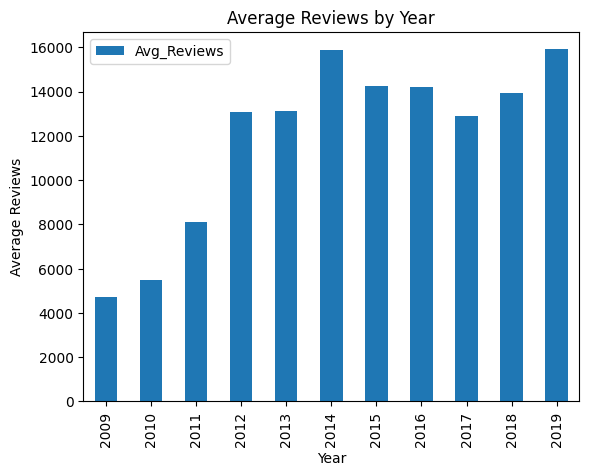

In [23]:
#Постройте гистограмму среднего количества рецензий по годам
avg_reviews_by_year = spark_session.sql("SELECT Year, AVG(Reviews) AS Avg_Reviews FROM Bestsellers GROUP BY Year ORDER BY Year")

avg_reviews_by_year.toPandas().plot(kind='bar', x='Year', y='Avg_Reviews')
plt.title('Average Reviews by Year')
plt.xlabel('Year')
plt.ylabel('Average Reviews')
plt.show()

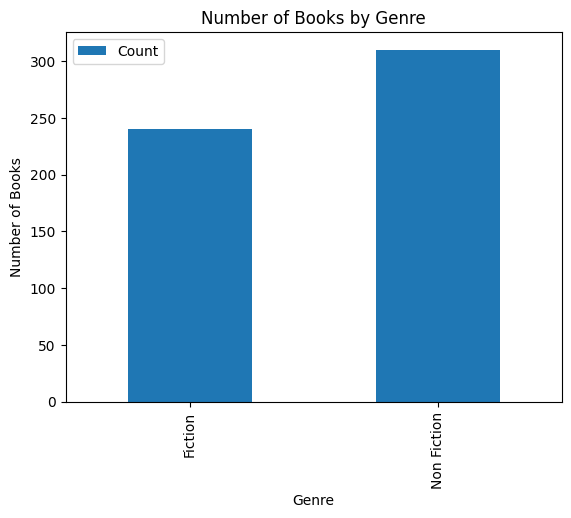

In [25]:
#Количество книг жанра "Fiction" и "Non Fiction" за весь доступный период
books_by_genre = spark_session.sql("SELECT Genre, COUNT(*) AS Count FROM Bestsellers GROUP BY Genre")

books_by_genre.toPandas().plot(kind='bar', x='Genre', y='Count')
plt.title('Number of Books by Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Books')
plt.show()